In [1]:
import pandas as pd
import torch
from torch.utils.data import Dataset, DataLoader
from transformers import RobertaTokenizer, RobertaForSequenceClassification, AdamW, get_linear_schedule_with_warmup
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, f1_score
from tqdm import tqdm
import wandb
import numpy as np


c:\anaconda\envs\nlp\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
c:\anaconda\envs\nlp\lib\site-packages\transformers\utils\generic.py:441: FutureWarning: `torch.utils._pytree._register_pytree_node` is deprecated. Please use `torch.utils._pytree.register_pytree_node` instead.
  _torch_pytree._register_pytree_node(
c:\anaconda\envs\nlp\lib\site-packages\transformers\utils\generic.py:309: FutureWarning: `torch.utils._pytree._register_pytree_node` is deprecated. Please use `torch.utils._pytree.register_pytree_node` instead.
  _torch_pytree._register_pytree_node(
c:\anaconda\envs\nlp\lib\site-packages\transformers\utils\generic.py:309: FutureWarning: `torch.utils._pytree._register_pytree_node` is deprecated. Please use `torch.utils._pytree.register_pytree_node` instead.
  _torch_pytree._register_pytree_node(


In [2]:
emotion_list = [
    "admiration", "amusement", "anger", "annoyance", "approval", "caring", "confusion",
    "curiosity", "desire", "disappointment", "disapproval", "disgust", "embarrassment",
    "excitement", "fear", "gratitude", "grief", "joy", "love", "nervousness", "optimism",
    "pride", "realization", "relief", "remorse", "sadness", "surprise", "neutral"
]

ekman_mapping = {
    "anger": ["anger", "annoyance", "disapproval"],
    "disgust": ["disgust"],
    "fear": ["fear", "nervousness", "confusion"],
    "joy": ["admiration", "amusement", "approval", "caring", "desire", "excitement",
            "gratitude", "joy", "love", "optimism", "pride", "relief"],
    "sadness": ["sadness", "disappointment", "embarrassment", "grief", "remorse"],
    "surprise": ["surprise", "realization", "curiosity"],
    "neutral": ["neutral"]
}

# Tạo ánh xạ label gốc -> ekman
label2ekman = {}
for ekman_label, label_list in ekman_mapping.items():
    for orig_label in label_list:
        label2ekman[orig_label] = ekman_label

# Tạo ánh xạ ekman -> index
ekman_to_index = {k: i for i, k in enumerate(sorted(ekman_mapping.keys()))}
index_to_ekman = {v: k for k, v in ekman_to_index.items()}
num_labels = len(ekman_to_index)
print(f"ekman_to_index: {ekman_to_index}")


ekman_to_index: {'anger': 0, 'disgust': 1, 'fear': 2, 'joy': 3, 'neutral': 4, 'sadness': 5, 'surprise': 6}


In [3]:
import pandas as pd

df = pd.read_csv(r"D:\train.tsv", sep="\t", header=None, names=["text", "label", "id"])
print(df.head())


                                                text label       id
0  My favourite food is anything I didn't have to...    27  eebbqej
1  Now if he does off himself, everyone will thin...    27  ed00q6i
2                     WHY THE FUCK IS BAYLESS ISOING     2  eezlygj
3                        To make her feel threatened    14  ed7ypvh
4                             Dirty Southern Wankers     3  ed0bdzj


In [4]:
def parse_labels(x):
    try:
        ids = [int(p.strip()) for p in str(x).split(",")]
        return ids
    except:
        return []

df["label_ints"] = df["label"].apply(parse_labels)

def map_to_ekman(ids):
    ekman_set = set()
    for id_ in ids:
        orig_label = emotion_list[id_]
        ekman_label = label2ekman[orig_label]
        ekman_set.add(ekman_label)
    return list(ekman_set)

df["ekman_labels"] = df["label_ints"].apply(map_to_ekman)

def ekman_to_onehot(ekman_labels):
    vec = [0] * num_labels
    for label in ekman_labels:
        vec[ekman_to_index[label]] = 1
    return vec

df["label_vec"] = df["ekman_labels"].apply(ekman_to_onehot)

print(df[["text", "ekman_labels", "label_vec"]].head())


                                                text ekman_labels  \
0  My favourite food is anything I didn't have to...    [neutral]   
1  Now if he does off himself, everyone will thin...    [neutral]   
2                     WHY THE FUCK IS BAYLESS ISOING      [anger]   
3                        To make her feel threatened       [fear]   
4                             Dirty Southern Wankers      [anger]   

               label_vec  
0  [0, 0, 0, 0, 1, 0, 0]  
1  [0, 0, 0, 0, 1, 0, 0]  
2  [1, 0, 0, 0, 0, 0, 0]  
3  [0, 0, 1, 0, 0, 0, 0]  
4  [1, 0, 0, 0, 0, 0, 0]  


In [5]:
from sklearn.model_selection import train_test_split

train_df, temp_df = train_test_split(df, test_size=0.2, random_state=42)
val_df, test_df = train_test_split(temp_df, test_size=0.5, random_state=42)

print(f"Train: {len(train_df)}, Val: {len(val_df)}, Test: {len(test_df)}")


Train: 34728, Val: 4341, Test: 4341


In [6]:
class EmotionDataset(Dataset):
    def __init__(self, df, tokenizer, max_length=128):
        self.df = df
        self.tokenizer = tokenizer
        self.max_length = max_length
        
    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        encoding = self.tokenizer(
            row["text"], truncation=True, padding="max_length",
            max_length=self.max_length, return_tensors="pt")
        item = {key: val.squeeze() for key, val in encoding.items()}
        item["labels"] = torch.tensor(row["label_vec"], dtype=torch.float)
        return item


In [9]:
from transformers import RobertaTokenizer, RobertaForSequenceClassification, get_linear_schedule_with_warmup
import wandb
from tqdm import tqdm
import numpy as np
from sklearn.metrics import f1_score, hamming_loss, accuracy_score

wandb.init(
    project="roberta-emotion",
    name="roberta-multilabel-run1",
    config={
        "model": "roberta-base",
        "batch_size": 16,
        "lr": 2e-5,
        "epochs": 10,
    }
)

tokenizer = RobertaTokenizer.from_pretrained("roberta-base")

train_ds = EmotionDataset(train_df, tokenizer)
val_ds = EmotionDataset(val_df, tokenizer)
test_ds = EmotionDataset(test_df, tokenizer)

train_loader = torch.utils.data.DataLoader(train_ds, batch_size=16, shuffle=True)
val_loader = torch.utils.data.DataLoader(val_ds, batch_size=16)
test_loader = torch.utils.data.DataLoader(test_ds, batch_size=16)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = RobertaForSequenceClassification.from_pretrained(
    "roberta-base", num_labels=num_labels, problem_type="multi_label_classification").to(device)

optimizer = torch.optim.AdamW(model.parameters(), lr=2e-5)
scheduler = get_linear_schedule_with_warmup(
    optimizer, num_warmup_steps=0,
    num_training_steps=len(train_loader) * 5)  # 5 epochs

num_epochs = 5
threshold = 0.5  # cắt nhị phân multi-label

for epoch in range(num_epochs):
    model.train()
    total_loss = 0
    for batch in tqdm(train_loader, desc=f"Training Epoch {epoch+1}"):
        optimizer.zero_grad()
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device).float()  # multi-label BCE expects float
        
        outputs = model(input_ids=input_ids, attention_mask=attention_mask, labels=labels)
        loss = outputs.loss
        loss.backward()
        optimizer.step()
        scheduler.step()
        
        total_loss += loss.item()
    
    avg_train_loss = total_loss / len(train_loader)
    print(f"Epoch {epoch+1} - Train loss: {avg_train_loss:.4f}")

    # ===== Validation =====
    model.eval()
    all_preds, all_labels = [], []
    with torch.no_grad():
        for batch in tqdm(val_loader, desc="Validating"):
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].cpu().numpy()
            
            outputs = model(input_ids=input_ids, attention_mask=attention_mask)
            logits = outputs.logits
            probs = torch.sigmoid(logits).cpu().numpy()
            preds = (probs >= threshold).astype(int)
            
            all_preds.append(preds)
            all_labels.append(labels)
    
    all_preds = np.vstack(all_preds)
    all_labels = np.vstack(all_labels)
    
    macro_f1 = f1_score(all_labels, all_preds, average="macro", zero_division=0)
    hamming = hamming_loss(all_labels, all_preds)
    subset_acc = accuracy_score(all_labels, all_preds)  # strict: tất cả nhãn phải khớp
    
    print(f"Epoch {epoch+1} - Val Macro F1: {macro_f1:.4f}, Hamming Loss: {hamming:.4f}, Subset Acc: {subset_acc:.4f}")
    
    # Log lên wandb
    wandb.log({
        "epoch": epoch + 1,
        "train_loss": avg_train_loss,
        "val_macro_f1": macro_f1,
        "val_hamming_loss": hamming,
        "val_subset_acc": subset_acc,
    })
    
    # Lưu model mỗi epoch
    checkpoint_name = f"roberta_multilabel_epoch{epoch+1}.pth"
    torch.save(model.state_dict(), checkpoint_name)
    wandb.save(checkpoint_name)

wandb.finish()


c:\anaconda\envs\nlp\lib\site-packages\huggingface_hub\file_download.py:943: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.out_proj.weight', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Training Epoch 1: 100%|██████████| 2171/2171 [06:24<00:00,  5.64it/s]


Epoch 1 - Train loss: 0.2570


Validating: 100%|██████████| 272/272 [00:12<00:00, 21.49it/s]


Epoch 1 - Val Macro F1: 0.5422, Hamming Loss: 0.0920, Subset Acc: 0.5927


Training Epoch 2: 100%|██████████| 2171/2171 [06:44<00:00,  5.36it/s]


Epoch 2 - Train loss: 0.2098


Validating: 100%|██████████| 272/272 [00:13<00:00, 20.11it/s]


Epoch 2 - Val Macro F1: 0.5831, Hamming Loss: 0.0901, Subset Acc: 0.6056


Training Epoch 3: 100%|██████████| 2171/2171 [06:45<00:00,  5.35it/s]


Epoch 3 - Train loss: 0.1838


Validating: 100%|██████████| 272/272 [00:13<00:00, 20.15it/s]


Epoch 3 - Val Macro F1: 0.5851, Hamming Loss: 0.0940, Subset Acc: 0.6012


Training Epoch 4: 100%|██████████| 2171/2171 [06:45<00:00,  5.36it/s]


Epoch 4 - Train loss: 0.1576


Validating: 100%|██████████| 272/272 [00:13<00:00, 20.12it/s]


Epoch 4 - Val Macro F1: 0.5848, Hamming Loss: 0.0975, Subset Acc: 0.5943


Training Epoch 5: 100%|██████████| 2171/2171 [06:41<00:00,  5.40it/s]


Epoch 5 - Train loss: 0.1367


Validating: 100%|██████████| 272/272 [00:13<00:00, 20.30it/s]


Epoch 5 - Val Macro F1: 0.5864, Hamming Loss: 0.0974, Subset Acc: 0.6006


epoch,▁▃▅▆█
train_loss,█▅▄▂▁
val_hamming_loss,▃▁▅██
val_macro_f1,▁▇███
val_subset_acc,▁█▆▂▅
epoch,5
train_loss,0.13666
val_hamming_loss,0.09738
val_macro_f1,0.58636
val_subset_acc,0.60055


In [11]:
model.eval()
all_test_preds = []

with torch.no_grad():
    for batch in tqdm(test_loader, desc="Predicting Test Set"):
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)

        outputs = model(input_ids=input_ids, attention_mask=attention_mask)
        logits = outputs.logits
        probs = torch.sigmoid(logits).cpu().numpy()  # multi-label: dùng sigmoid

        preds = (probs >= threshold).astype(int)  # threshold = 0.5
        all_test_preds.append(preds)

all_test_preds = np.vstack(all_test_preds)  # (num_samples, num_labels)



Predicting Test Set: 100%|██████████| 272/272 [00:12<00:00, 21.91it/s]


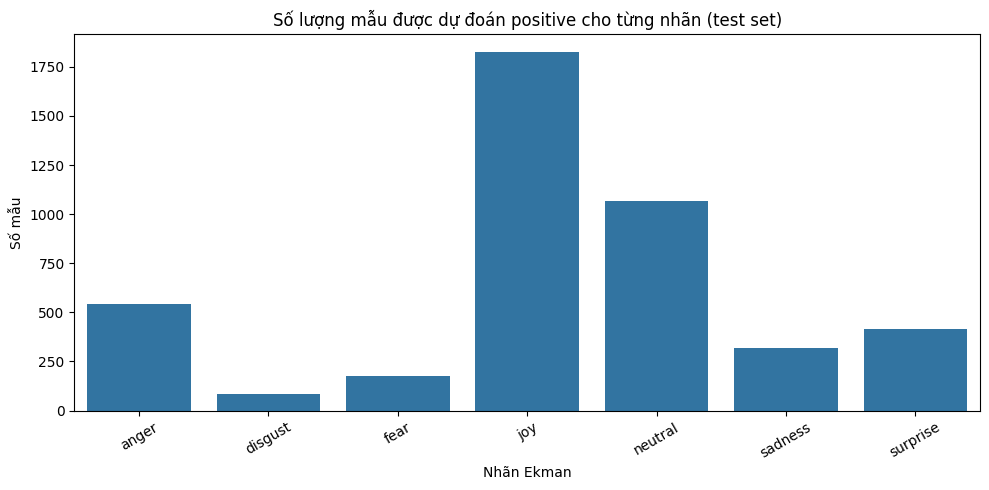

✅ Đã lưu biểu đồ phân bố label vào label_distribution.png


In [12]:
import matplotlib.pyplot as plt
import seaborn as sns

# Lấy lại tên nhãn Ekman theo đúng thứ tự index
ekman_labels = [index_to_ekman[i] for i in range(len(index_to_ekman))]

# Đếm tổng số nhãn được dự đoán là 1 cho mỗi class
label_counts = np.sum(all_test_preds, axis=0)

plt.figure(figsize=(10, 5))
sns.barplot(x=ekman_labels, y=label_counts)
plt.title("Số lượng mẫu được dự đoán positive cho từng nhãn (test set)")
plt.ylabel("Số mẫu")
plt.xlabel("Nhãn Ekman")
plt.xticks(rotation=30)
plt.tight_layout()
plt.savefig("label_distribution.png")
plt.show()

print("✅ Đã lưu biểu đồ phân bố label vào label_distribution.png")
